<a href="https://colab.research.google.com/github/KAFE45/Colab-LabBCI/blob/main/EEG_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Markers from File 1:
Timestamp: 4131.04, Marker: 4
Timestamp: 4149.37, Marker: 14
Timestamp: 4149.37, Marker: 1
Timestamp: 4156.79, Marker: 11
Timestamp: 4156.79, Marker: 4
Timestamp: 4174.95, Marker: 14
Timestamp: 4174.95, Marker: 2
Timestamp: 4203.38, Marker: 12
Timestamp: 4203.38, Marker: 4
Timestamp: 4235.87, Marker: 14
Timestamp: 4235.87, Marker: 3
Timestamp: 4279.99, Marker: 13
Timestamp: 4280.00, Marker: 4


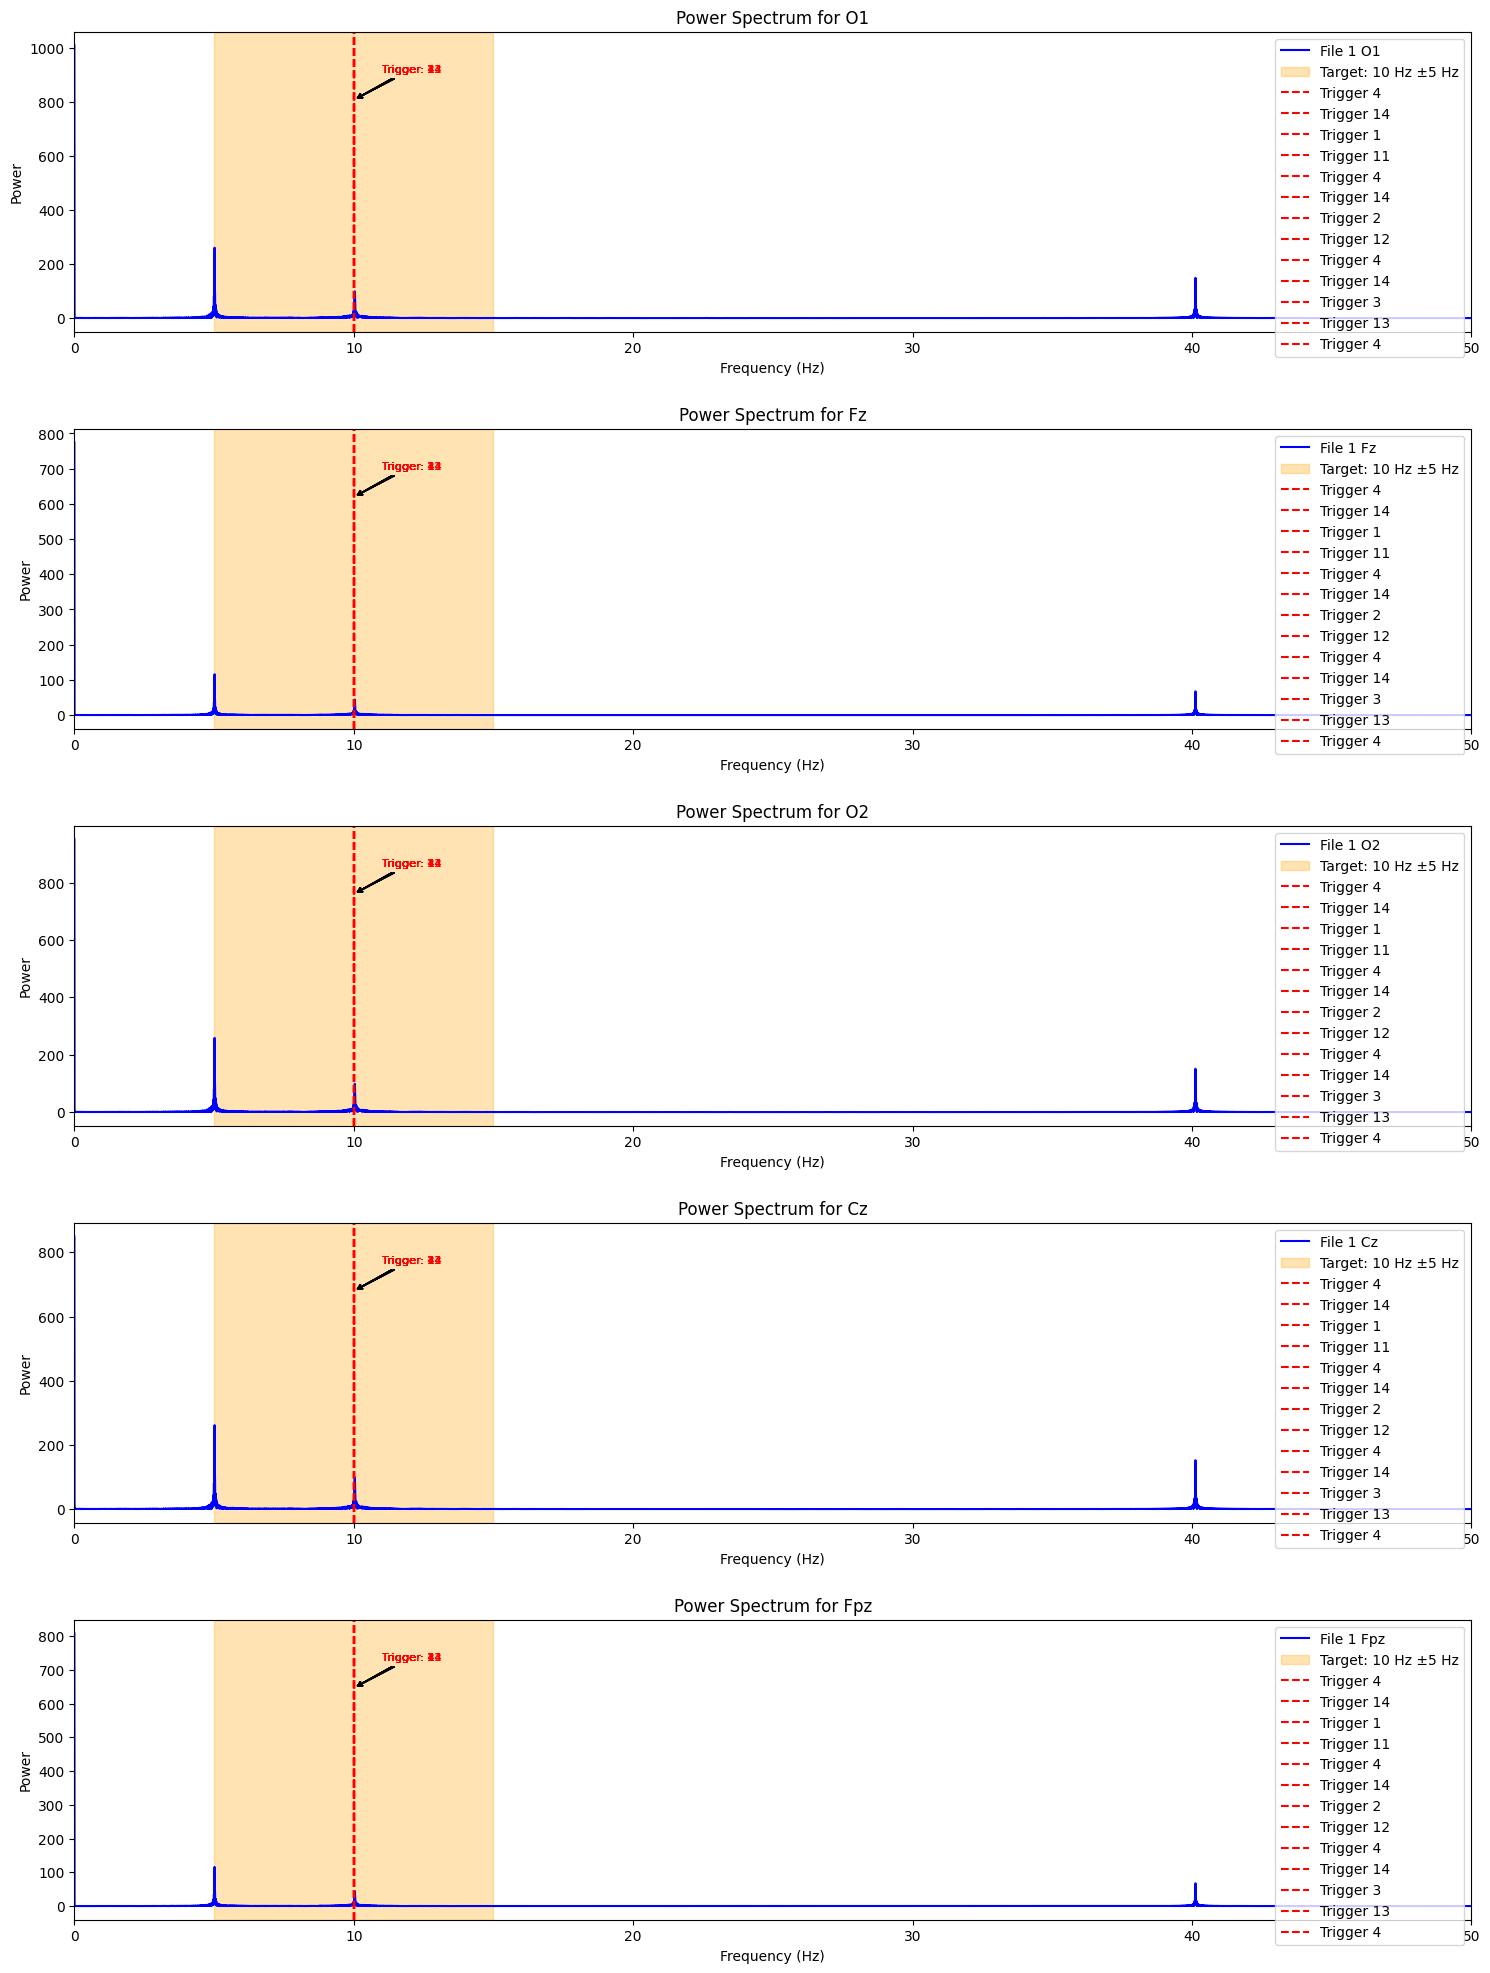

In [17]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt


from google.colab import files
import io

# # อัปโหลดไฟล์
# uploaded = files.upload()

# # ตรวจสอบชื่อไฟล์ที่อัปโหลดและอ่านไฟล์
# file_name = list(uploaded.keys())[0]  # เลือกไฟล์แรกที่อัปโหลด

# # Load the data จากไฟล์ที่อัปโหลด
# df1, sampling_rate1, markers1 = load_data(io.BytesIO(uploaded[file_name]))



# Load data from .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot Power Spectrum with FFT
def plot_power_spectrum_fft(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freq=10, bandwidth=5):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # FFT of the signal
            N = len(signal)
            T = 1.0 / sampling_rate
            yf = fft(signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Plot power spectrum
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')

            # Set frequency range to 0-50 Hz
            plt.xlim(0, 50)  # กำหนดความยาวของ Spectrum

            # Highlight the target frequency range
            plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            # Mark triggers with vertical lines in the time domain (just for reference)
            for timestamp, marker in markers:
                plt.axvline(x=target_freq, color='red', linestyle='--', label=f'Trigger {marker[0]}')
                plt.annotate(f'Trigger: {marker[0]}',
                             xy=(target_freq, max(power_spectrum) * 0.8),
                             xytext=(target_freq + 1, max(power_spectrum) * 0.9),
                             arrowprops=dict(facecolor='black', arrowstyle='->'),
                             fontsize=8,
                             color='red')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# # Load the data
df1, sampling_rate1, markers1 = load_data('/content/sub-sub-testV2EEG_ses-ses-SSVEP05.02.4_task-Default_run-001_eeg.xdf')


# Print the markers for debugging purposes
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Select the channels to plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Fpz']

# Plot the power spectrum using FFT for the first file
plot_power_spectrum_fft(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freq=10)

# Show the plot
plt.show()
